# Manipulando datos categóricos

In [60]:
import pandas as pd

Comúnmente los conjuntos de datos contienen datos categóricos. Es importante distinguir entre datos categóricos ordinales y nominales; los ordinales son aquellos que pueden ser ordenados (p.e., en la talla de una prenda M < G < XG); en los nominales no tiene mucho sentido pensar en un orden (p.e., en el color de una prenda).

### Datos ordinales

In [61]:
df = pd.DataFrame([
    ['verde', 'M', 10.3, 'clase1'],
    ['rojo', 'G', 14.2, 'clase2'],
    ['azul', 'XG', 15.6, 'clase1'],
])

df.columns = ['color', 'talla', 'precio', 'clase']
df

,color,talla,precio,clase
0,verde,M,10.3,clase1
1,rojo,G,14.2,clase2
2,azul,XG,15.6,clase1


Este conjunto de datos contiene una característica nominal (color) una ordinal (talla) y una numérica (precio). Este conjunto puede utilizarse en un algoritmo supervisado, dado que las
etiquetas de la clase a la que pertenece cada muestra en la última columna.

### Mapeando valores ordinales

In [62]:
import numpy as np

In [63]:
talla_map = {et: ind for ind, et in enumerate(np.unique(df.talla))} 
# No sirve por el orden de las tallas M < G < XG
talla_map

{'G': 0, 'M': 1, 'XG': 2}

Para garantizar que nuestros algoritmos interpretan correctamente características ordinales, es necesario convertir estas características en valores enteros; desafortunadamente no hay una
función que pueda determinar automáticamente el orden correcto a partir de las etiquetas de la talla; por lo tanto, en general se debe realizar este proceso manualmente (con ayuda de un
diccionario):

In [64]:
talla_map = {'M': 0, 'G': 1, 'XG': 2}
df['talla'] = df['talla'].map(talla_map) #['talla'] es equivalente a .talla
df

,color,talla,precio,clase
0,verde,0,10.3,clase1
1,rojo,1,14.2,clase2
2,azul,2,15.6,clase1


### Codificando las etiquetas de clase

Muchas algoritmos de aprendizaje requieren que las etiquetas de clase esten codificadas como números enteros. Aunque la mayoría de los algoritmos que provee scikit-learn pueden realizar
esta conversión internamente, es una buena práctica proveer las etiquetas como enteros y como las clases no son ordinales no importa qué número se asigna a cada una de ellas. Por lo tanto,
podemos enumerar las etiquetas de clase comenzando con 0:

In [65]:
clase_map = {et: ind for ind, et in enumerate(np.unique(df['clase']))}
clase_map

{'clase1': 0, 'clase2': 1}

A continuación podemos usar el diccionario para realizar la conversión de las etiquetas de
clase a enteros:


In [66]:
df.clase = df.clase.map(clase_map)
df

,color,talla,precio,clase
0,verde,0,10.3,0
1,rojo,1,14.2,1
2,azul,2,15.6,0


### Codificando valores nominales en formaro one-hot

Podemos realizar un proceso similar para la columna color (dado que no se requiere orden).

In [67]:
color_map = {et: ind for ind, et in enumerate(np.unique(df.color))}
# No sirve porque no hay un orden en los colores
color_map

{'azul': 0, 'rojo': 1, 'verde': 2}

Si nos detuviéramos en este punto, estaríamos cayendo en uno de los errores más comúnes
cuando se utilizan datos categóricos: los colores no tienen un orden particular; sin embargo un
algoritmo de aprendizaje supondría que verde es mayor que rojo y que rojo es mayor que azul.
Esta suposición no es correcta y aunque se podría obtener un buen resultado, en general puede
no ser óptimo.

Una posible solución es utilizar la técnica conocida como codificación one-hot. La idea
básica es crear una nueva característica ficticia (dummy) por cada valor único de la columna
nominal correspondiente. En este caso, se generarán tres columnas: azul, rojo y verde. Se utilizan
valores binarios para indicar el color particular de cada muestra.
Para realizar esta transformación se puede utilizar el OneHotEncoder disponible en el módulo
preprocessing de sci-kitlearn:

In [68]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[['color']])
ohe.transform(df[['color']]).toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

Una forma más conveniente para crear esas características ficticias para la codificación onehot, es utilizar el método get_dummies implementado en pandas. Si se aplica a un DataFrame,
este método convertirá solamente las columnas de tipo string y dejará las otras columnas sin
cambios 

In [69]:
# Con pandas (Recomendado)
pd.get_dummies(df['color'])

,azul,rojo,verde
0,False,False,True
1,False,True,False
2,True,False,False


In [71]:
pd.get_dummies(df[['precio', 'color', 'talla']])

,precio,talla,color_azul,color_rojo,color_verde
0,10.3,0,False,False,True
1,14.2,1,False,True,False
2,15.6,2,True,False,False


In [50]:
pd.get_dummies(df['color'], drop_first=True)

,rojo,verde
0,False,True
1,True,False
2,False,False


### Escalamiento de características

Este es otro paso clave en el preprocesamiento de datos; muchos algoritmos de aprendizaje y
optimización tienen mejor comportamiento si las características discriminantes se encuentran en
la misma escala.

Existen dos enfoques comunes para escalar características:

***Normalización***, se se refiere al reescalamiento de cada característica en el intervalo [0, 1].
Para esto, se aplica el escalamiento min-max en cada columna:

$$ x^{(i)}_{norm} = \frac{x^{(i)}-x_{min}}{x_{max}-x_{min}} $$

Donde $x^{(i)}$ es una muestra particular, $x_{min}$ es el valor mínimo de la columna y $x_{max}$ el máximo.

***Estandarización***, este prepocesamiento puede resultar más práctico para algoritmos de
optimización (p.e. gradient descent), esto se debe a que muchos modelos inicializan sus
pesos a valores cercanos a 0. Utilizando estandarización, se centran las columnas de características a media 0 con desviación estándar 1. Además, la estandarización mantiene
información útil sobre secciones aisladas y hace que los algoritmos sean menos sensibles a
ellas en contraste al escalamiento min-max. El procedimiento de estandarización se realiza con:

$$ x^{(i)}_{std} = \frac{x^{i}-\mu_x}{\sigma_x} $$

donde $\mu_x$ es la media muestral de una columna particular y $\sigma_x$ es su correspondiente dessviación estándar.

Otro enfoque menos usado se conoce como Normalizer :
***Normalizer***, escala las muestras individuales a vectores unitarios; es decir, cada muestra
(renglón de la matriz de datos) con al menos un compnente difrente de cero se reescala
independientemente de las otras muestras de forma que su norma sea cero.:

$$ x^{(i)}_{nz} = \frac{x^{(i)}}{||x||} $$

donde $||x||$ es la norma de la muestra (renglón de la matriz).

In [51]:
x = np.array([0,1,2,3,4,5,6])
print('Normalizado  :', (x - x.min()) / (x.max() - x.min()))
print('Estandarizado:', (x - x.mean()) / x.std())
print('Normalizer   :', x / np.linalg.norm(x))


Normalizado  : [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
Estandarizado: [-1.5 -1.  -0.5  0.   0.5  1.   1.5]
Normalizer   : [0.         0.10482848 0.20965697 0.31448545 0.41931393 0.52414242
 0.6289709 ]


In [72]:
from sklearn import datasets
from sklearn.model_selection import train_test_split 

In [73]:
iris = datasets.load_iris()
# sepal length, petal length
X = iris.data[:, [2, 3]]
# target : 0, 1, 2 (setosa, versicolor, virginica)
y = iris.target[:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [75]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train) # datos de entrenamiento
X_test_norm = mms.transform(X_test) # datos de prueba
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()
X_train_std = stds.fit_transform(X_train) # datos de entrenamiento
X_test_std = stds.transform(X_test) # datos de prueba
from sklearn.preprocessing import Normalizer
nz = Normalizer()
X_train_nz = nz.fit_transform(X_train) # datos de entrenamiento
X_test_nz = nz.transform(X_test) # datos de prueba

### Detección de anomalías

Detectar anomalías es muy útil cuando se está realizando el preprocesamiento de datos: puede
ayudar a evitar sesgos no deseados 

In [52]:
import matplotlib.pyplot as plt

### Normalidad de la distribución

Para verificar la normalidad de una variable aleatoria es posible utilizar alguna de las siguientes
técnicas:

- Realizar un histograma y ver si parece normal
- Hacer una gráfica *Quantile-Quantile Normal*
- Realizar un contraste de normalidad *Shapiro-Wilks*
- Hacer un diagrama de dispersión por pares de variables (*PairPlot*)

In [53]:
# Conjunto de datos ficticio con distribución normal
data = np.random.randn(50000) * 20 + 20

Histograma

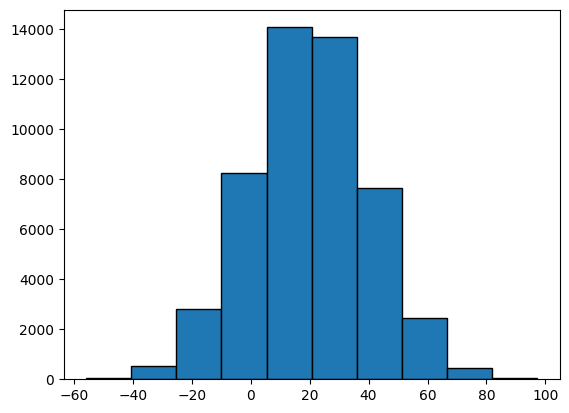

In [54]:
plt.hist(data, edgecolor='black')
plt.show()

Gráfica de cuantiles

In [55]:
import pylab
import scipy.stats as stats

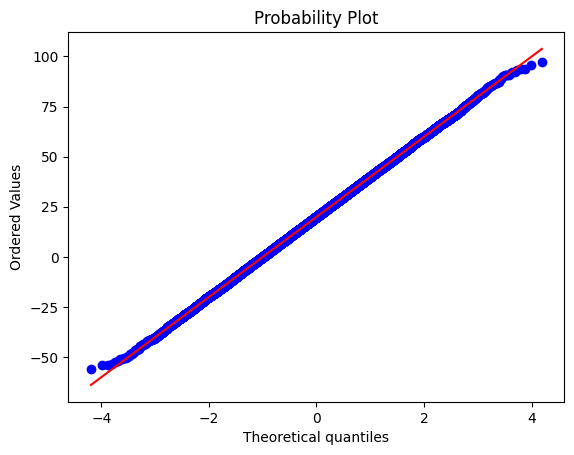

In [56]:
stats.probplot(data, dist='norm', plot=pylab)
pylab.show()

Prueba de Shapiro

In [57]:
_, p_value = stats.shapiro(data)
print('p_value = ', p_value)
# p_value > 0.05 => La distribución es normal

p_value =  0.8737310034049639


C:\Users\denis\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50000.
  res = hypotest_fun_out(*samples, **kwds)
